In [1]:
# pip install flake8 pycodestyle_magic

In [2]:
# %load_ext pycodestyle_magic

In [3]:
# %pycodestyle_on 

# Chargement des librairies

In [4]:
import datetime
from datetime import timedelta
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, \
    InterclusterDistance
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings  # supress warnings
warnings.filterwarnings('ignore')

# Récupération des données

In [5]:
commande = pd.read_csv("/Users/gauthierrault/Desktop/P5/commande.csv")

rfm = pd.read_csv("/Users/gauthierrault/Desktop/P5/rfm.csv")

rfm_review = pd.read_csv("/Users/gauthierrault/Desktop/P5/rfm_review.csv")

In [6]:
commande.drop(['Unnamed: 0'], axis=1, inplace=True)

In [7]:
commande.set_index(['customer_unique_id'], inplace=True)

In [8]:
rfm.set_index(['customer_unique_id'], inplace=True)

In [9]:
rfm_review.set_index(['customer_unique_id'], inplace=True)

In [10]:
# Transformation timestamps en datetime
time = ["order_purchase_timestamp", "order_approved_at",
        "order_delivered_carrier_date", "order_delivered_customer_date",
        "order_estimated_delivery_date"]
for cols in time:
    commande[cols] = pd.to_datetime(commande[cols], format="%Y-%m-%d", errors="ignore")

In [11]:
def periode(df, start=None, period=30) :
    date=df['order_purchase_timestamp'].apply(lambda x :x.date())
    if start is None :
        start=df['order_purchase_timestamp'].min().date()
    end=start + timedelta(days=period)
    odf=df[(date >= start) & (date <= end)]
    return odf

In [12]:
def transformer(df):
    aggr = {
        'order_id' : lambda x : len(x.unique()), # Nombre de commande sur la période
        'days_orders' : lambda x : x.min(), # nombre de jour depuis la dernière commande
        "payment_value" : "sum",
        "review_score" : "mean"}
    END = df['order_purchase_timestamp'].max().date()
    days_order = df["order_purchase_timestamp"].apply(lambda x : (END-x.date()).days).tolist()
    df = pd.concat([df, pd.Series(data = days_order, index = df.index,name = 'days_orders')], axis = 1)
    odf = df.groupby("customer_unique_id").agg(aggr)
    odf.rename(columns = {"order_id": "n_orders"}, inplace =True)
    col = ["n_orders", "n_days_last_order", 'total_price', 'mean_review_score']
    odf.columns = col 
    return odf

In [13]:
print(f"Premier jour de la BDD : {commande['order_purchase_timestamp'].min()}")
print(f"Dernier jour de la BDD : {commande['order_purchase_timestamp'].max()}")

Premier jour de la BDD : 2016-09-15 12:16:38
Dernier jour de la BDD : 2018-08-29 15:00:37


In [14]:
tinit = 180
data_init = periode(commande, period=tinit)
print(f"Premier jour de la BDD : {data_init['order_purchase_timestamp'].min().date()}")
print(f"Dernier jour de la BDD : {data_init['order_purchase_timestamp'].max().date()}")

Premier jour de la BDD : 2016-09-15
Dernier jour de la BDD : 2017-03-14


In [15]:
data_init = transformer(data_init)
cust_init = data_init.index
data_init.head()

,n_orders,n_days_last_order,total_price,mean_review_score
customer_unique_id,,,,
0000f46a3911fa3c0805444483337064,1,4,86.22,3.0
0005e1862207bf6ccc02e4228effd9a0,1,10,150.12,4.0
00115fc7123b5310cf6d3a3aa932699e,1,52,76.11,4.0
002b4cd83fabaffaa475f78ea5ef3e08,1,41,64.42,2.0
0032c76b20340da25249092a268ce66c,1,159,144.94,4.0


In [16]:
scaler_init = preprocessing.StandardScaler().fit(data_init)
data_init_norm = scaler_init.transform(data_init)

In [17]:
cls_init = KMeans(n_clusters=4, n_init=20, random_state=0)
cls_init.fit(data_init_norm)
pred_init = pd.Series(index=cust_init, data=cls_init.predict(data_init_norm))

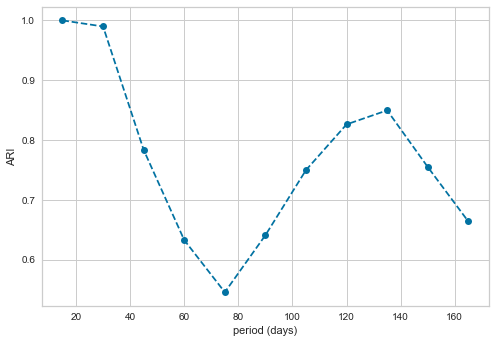

In [18]:
ARI = []
periods = range(15, 180, 15)
for days in periods:
    data_step = periode(commande, period=tinit+days)
    data_step = transformer(data_step)
    data_step_oldnorm = scaler_init.transform(data_step)
    pred_step_no_update = cls_init.predict(data_step_oldnorm)
    scaler_step = preprocessing.StandardScaler().fit(data_step)
    data_step_norm = scaler_step.transform(data_step)
    cls_step = KMeans(n_clusters=4, n_init=20, random_state=0)
    cls_step.fit(data_step_norm)
    pred_step_update = cls_step.predict(data_step_norm)
    ARI.append(metrics.adjusted_rand_score(pred_step_no_update, pred_step_update))
fig, ax = plt.subplots()
ax.plot(periods, ARI, linestyle="--", marker="o")
ax.set_xlabel('period (days)')
ax.set_ylabel('ARI')
plt.show()

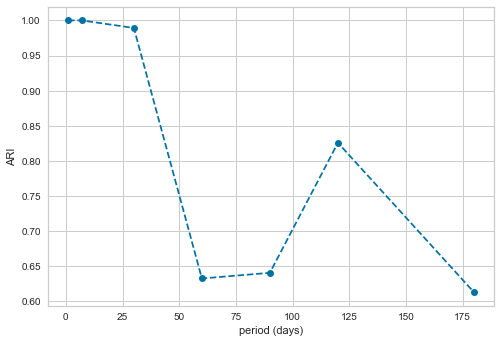

In [19]:
ARI = []
periods = [1, 7, 30,  60, 90, 120, 180]
for days in periods:
    data_step = periode(commande, period=tinit+days)
    data_step = transformer(data_step)
    data_step_oldnorm = scaler_init.transform(data_step)
    pred_step_no_update = cls_init.predict(data_step_oldnorm)
    scaler_step = preprocessing.StandardScaler().fit(data_step)
    data_step_norm = scaler_step.transform(data_step)
    cls_step = KMeans(n_clusters=4, n_init=20, random_state=0)
    cls_step.fit(data_step_norm)
    pred_step_update = cls_step.predict(data_step_norm)
    ARI.append(metrics.adjusted_rand_score(pred_step_no_update, pred_step_update))
fig, ax = plt.subplots()
ax.plot(periods, ARI, linestyle="--", marker="o")
ax.set_xlabel('period (days)')
ax.set_ylabel('ARI')
plt.show()

In [20]:
cls_init = KMeans(n_clusters=3, n_init=20, random_state=0)
cls_init.fit(data_init_norm)
pred_init = pd.Series(index=cust_init, data=cls_init.predict(data_init_norm))

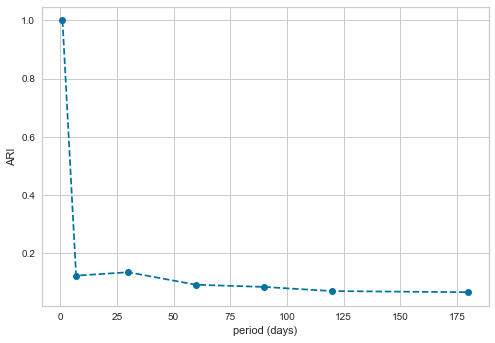

In [21]:
ARI = []
periods = [1, 7, 30,  60, 90, 120, 180]
for days in periods:
    data_step = periode(commande, period=tinit+days)
    data_step = transformer(data_step)
    data_step_oldnorm = scaler_init.transform(data_step)
    pred_step_no_update = cls_init.predict(data_step_oldnorm)
    scaler_step = preprocessing.StandardScaler().fit(data_step)
    data_step_norm = scaler_step.transform(data_step)
    cls_step = KMeans(n_clusters=3, n_init=20, random_state=0)
    cls_step.fit(data_step_norm)
    pred_step_update = cls_step.predict(data_step_norm)
    ARI.append(metrics.adjusted_rand_score(pred_step_no_update, pred_step_update))
fig, ax = plt.subplots()
ax.plot(periods, ARI, linestyle="--", marker="o")
ax.set_xlabel('period (days)')
ax.set_ylabel('ARI')
plt.show()

In [31]:
tinit = 90
dstart = datetime.datetime(2017, 1, 1).date()
data_init = periode(commande, start=dstart, period=tinit)
print(f"Premier jour de la BDD : {data_init['order_purchase_timestamp'].min().date()}")
print(f"Dernier jour de la BDD : {data_init['order_purchase_timestamp'].max().date()}")
data_init = transformer(data_init)
scaler_init = preprocessing.StandardScaler().fit(data_init)
data_init_norm = scaler_init.transform(data_init)
cls_init = KMeans(n_clusters=4, n_init=20, random_state=0)
cls_init.fit(data_init_norm)

Premier jour de la BDD : 2017-01-05
Dernier jour de la BDD : 2017-04-01


KMeans(n_clusters=4, n_init=20, random_state=0)

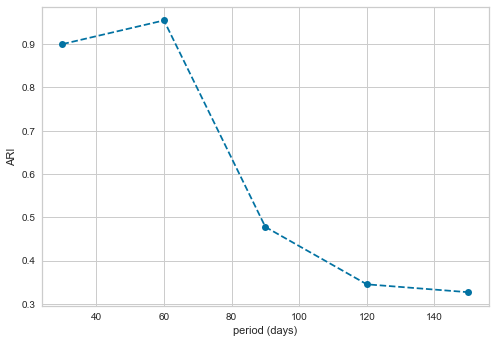

In [32]:
ARI = []
periods = range(30, 180, 30)
for days in periods:
    data_step = periode(commande, period=tinit+days)
    data_step = transformer(data_step)
    data_step_oldnorm = scaler_init.transform(data_step)
    pred_step_no_update = cls_init.predict(data_step_oldnorm)
    scaler_step = preprocessing.StandardScaler().fit(data_step)
    data_step_norm = scaler_step.transform(data_step)
    cls_step = KMeans(n_clusters=4, n_init=20, random_state=0)
    cls_step.fit(data_step_norm)
    pred_step_update = cls_step.predict(data_step_norm)
    ARI.append(metrics.adjusted_rand_score(pred_step_no_update, pred_step_update))
fig, ax = plt.subplots()
ax.plot(periods, ARI, linestyle="--", marker="o")
ax.set_xlabel('period (days)')
ax.set_ylabel('ARI')
plt.show()

In [42]:
tinit = 90
dstart = datetime.datetime(2018, 1, 1).date()
data_init = periode(commande, start=dstart, period=tinit)
print(f"Premier jour de la BDD : {data_init['order_purchase_timestamp'].min().date()}")
print(f"Dernier jour de la BDD : {data_init['order_purchase_timestamp'].max().date()}")
data_init = transformer(data_init)
scaler_init = preprocessing.StandardScaler().fit(data_init)
data_init_norm = scaler_init.transform(data_init)
cls_init = KMeans(n_clusters=4, n_init=20, random_state=0)
cls_init.fit(data_init_norm)

Premier jour de la BDD : 2018-01-01
Dernier jour de la BDD : 2018-04-01


KMeans(n_clusters=4, n_init=20, random_state=0)

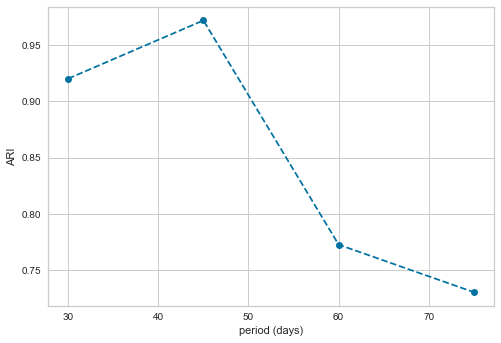

In [45]:
ARI = []
periods = range(30, 90, 15)
for days in periods:
    data_step = periode(commande, period=tinit+days)
    data_step = transformer(data_step)
    data_step_oldnorm = scaler_init.transform(data_step)
    pred_step_no_update = cls_init.predict(data_step_oldnorm)
    scaler_step = preprocessing.StandardScaler().fit(data_step)
    data_step_norm = scaler_step.transform(data_step)
    cls_step = KMeans(n_clusters=4, n_init=20, random_state=0)
    cls_step.fit(data_step_norm)
    pred_step_update = cls_step.predict(data_step_norm)
    ARI.append(metrics.adjusted_rand_score(pred_step_no_update, pred_step_update))
fig, ax = plt.subplots()
ax.plot(periods, ARI, linestyle="--", marker="o")
ax.set_xlabel('period (days)')
ax.set_ylabel('ARI')
plt.show()